### Model inference & visualization
This notebook is intended for visualizing inference results of our proposed method.

In [26]:
# Define imports and set global variables.

import numpy as np
import torch
import os.path as osp
from easydict import EasyDict
from model import BoundingBox3dV3QuantEulerNoRGB
from bbox3d_utils import depth2cloud, sample_bbox, quant_pc, quantile_box, masks_to_boxes, quaternions_to_rotmats, get_transforms_from_rotmats_and_translations, BatchBBox3D
import matplotlib.pyplot as plt

# What device to use, e.g. 'cpu' or 'cuda'.
DEVICE = 'cpu'

# The path to the weight checkpoint.
MODEL_SNAPSHOT_PATH = '/Users/msieb/Downloads/model_itr_11000.pth'

# The dataset root path.
DATASET_ROOT_DIR = '/Users/msieb/Downloads/eccv_dataset_2'
# From what split to visualize.
SPLIT_FOLDER = 'train'
# The sample index to visualize.
SAMPLE_INDEX = 0

# inference params
INFERENCE_MODE = 'quantile_box' # should be either `quantile_box` or `beam`

# quantile box params
N_SAMPLES = 64 # only used if `INFERENCE_MODE` is `quantile_box`
QUANTILE = 0.2
GRID_SIZE = 4

# beam search params
N_BEAMS = 50 # only used if `INFERENCE_MODE` is `beam` 


### Load some data

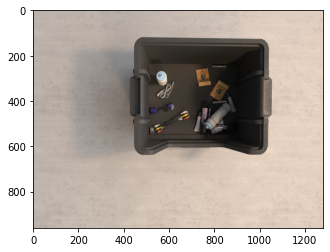

In [27]:

data_path = osp.join(DATASET_ROOT_DIR, SPLIT_FOLDER, '{:05d}'.format(SAMPLE_INDEX))
data = np.load(osp.join(data_path, 'data.npz'))
segm = np.load(osp.join(data_path, 'annotation/segm.npz'))

depth = torch.from_numpy(data['depth']).float().to(device=DEVICE) # shape(H, W)
intrinsic = torch.from_numpy(data['intrinsic']).float().to(device=DEVICE) # shape(3, 3)
normals = torch.from_numpy(data['normals']).float().to(device=DEVICE) # shape(3, H, W)

rgb = torch.from_numpy(data['rgb']).to(device=DEVICE) # shape(3, H, W)
mask_occ = torch.from_numpy(segm['masks']).to(device=DEVICE) # shape(N_objects, H, W)
mask_full = torch.from_numpy(segm['masks_amodal']).to(device=DEVICE) # shape(N_objects, H, W)

# Visualize some basic things
plt.imshow(data['rgb'].transpose(1, 2, 0))

### Load the model

In [28]:

# Define the model hyperparameters corresponding to the model checkpoint.
cfg = EasyDict(
    DISTRIBUTED=False,
    QUANT_PARAMS=EasyDict(
        LENGTH=[0.0, 11.0, 512],
        OFFSET=[-8.0, 11.0, 512],
        EULER=[[0, np.pi * 2, 512], [0, np.pi, 512], [0, np.pi * 2, 512]],
        LENGTH_SLICE=slice(0, 3),
        OFFSET_SLICE=slice(3, 6),
        EULER_SLICE=slice(6, 9),
    ),
)
model = BoundingBox3dV3QuantEulerNoRGB(cfg).to(device=DEVICE)


# Load the weights
state_dict = {}
for k, v in torch.load(MODEL_SNAPSHOT_PATH, map_location=torch.device('cpu'))['model'].items():
    k = k.replace('._', '.')
    state_dict[k[13:]] = v
model.load_state_dict(state_dict)



<All keys matched successfully>

### Run the model

In [29]:

point_cloud = depth2cloud(depth, intrinsic, rgb.shape[-2], rgb.shape[-1])[0].transpose(2, 1).transpose(1, 0)
mask_full_sum = mask_full.float().sum(dim=(1, 2))
occ_ratio = 1 - mask_occ.float().sum(dim=(1, 2)) / mask_full_sum

keep_indices = occ_ratio < 0.9 # we only want to predict objects that not totally occluded which is out of scope of the model.

model_inputs = dict(
    rgbs=None,
    im_size=torch.tensor([rgb.shape[-2], rgb.shape[-1]]).to(device=DEVICE),
    point_cloud=point_cloud,
    normals_pred=normals,
    boxes=masks_to_boxes(mask_full)[keep_indices],
    segm_feats=None,
    depth_feats=None,
    mask_occ=mask_occ[keep_indices],
    mask_full=mask_full[keep_indices],
    depth_valid=torch.ones_like(depth),
    depth_uncertainty=torch.ones_like(depth),
    occ_ratio=occ_ratio,
    bin_probs=torch.zeros(rgb.shape[-2], rgb.shape[-1]).to(device=DEVICE)
)
blobs = model.predict(
    **model_inputs
)
lengths, pos, quat, ent, logps = sample_bbox(
    blobs['feats'],
    blobs['ranges_patches'],
    blobs['means_patches'],
    N_SAMPLES if INFERENCE_MODE == 'quantile_box' else N_BEAMS,
    "random" if INFERENCE_MODE == 'quantile_box' else "beam",
    model.quant_order,
    model.autoreg,
    model.length_slice,
    model.offset_slice,
    model.euler_slice,
)
if INFERENCE_MODE == 'quantile_box':
    all_points, mean_inter, quat =  quant_pc(lengths, quat, pos, grid_size=GRID_SIZE)
    out = quantile_box(all_points, mean_inter, quat, quantile=QUANTILE)
elif INFERENCE_MODE == 'beam':
    out = dict(
            quat=quat[:, 0],
            dim=lengths[:, 0] * 2.0,
            position=pos[:, 0],
            logp=logps[:, 0]
        )
else:
    raise NotImplementedError(f"Inference mode {INFERENCE_MODE} is not implemented.")

valids = (
    torch.isfinite(out["dim"]).all(-1)
    & torch.isfinite(out["position"]).all(-1)
    & torch.isfinite(out["quat"]).all(-1)
)
boxes = BatchBBox3D(dimensions=out['dim'], poses=get_transforms_from_rotmats_and_translations(
                    rotmats=quaternions_to_rotmats(out["quat"]), translations=out["position"]
                ),valids=valids)

In [30]:
from scene_builder import SceneBuilder

# Initialize the scene builder
builder = SceneBuilder.from_point_map(
    depth2cloud(depth, intrinsic, rgb.shape[-2], rgb.shape[-1])[0], rgb.float(), flip_xz=True, size=2e-3, render_size=(480, 320)
)
# Add the predicted 3D bounding boxes
builder.add_bbox3d_batch(boxes)


Renderer(camera=PerspectiveCamera(aspect=1.5, fov=90.0, position=(-0.0004832812961675141, 0.6884695243338007, …